<font size="+3">Анализ результатов A/A/B-теста для определения влияния нового шрифта на поведение пользователей</font>

<font size="+2">Легенда и описание проекта</font>  
Исследование поведения пользователей производится для стартапа, который продаёт продукты питания через мобильное приложение.  
Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.

<font size="+2">Цель исследования</font>
- Выяснить, есть ли различия в поведении пользователей при внедрении нового шрифта.

<font size="+2">Задачи исследования</font>
- Узнать, как пользователи доходят до покупки;
- Выяснить, сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах и на каких именно;
- Изучить воронку продаж;
- Исследовать результаты A/A/B-теста.

<font size="+2">Содержание</font>
1. [Обзор данных с результатами A/A/B-теста](#start)
2. [Предобработка данных](#prepare)
3. [Исследовательский анализ данных](#eda)  
4. [Изучение воронки событий](#funnel)
5. [Изучение результатов A/A/B-теста](#ab-test_explore)
6. [Общий вывод](#conclusion)

# Обзор данных с результатами A/A/B-теста <a id='start'></a>

## Датасет с действиями пользователей и событиями
Загрузим файл, где содержатся данные с действиями пользователей и событиями:

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import math as mth
from scipy import stats as st

In [10]:
pd.options.mode.chained_assignment = None

In [11]:
try:
    logs = pd.read_csv('local_dataset.csv', sep='\t')
except:
    logs = pd.read_csv('url_to_dataset', sep='\t')

In [12]:
logs.head(5)  # Вывод первых 5 строк для первичного ознакомления с датасетом

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [13]:
logs.tail(5)  # Вывод последних 5 строк для первичного ознакомления с датасетом

,EventName,DeviceIDHash,EventTimestamp,ExpId
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246
244125,OffersScreenAppear,5746969938801999050,1565212517,246


Судя по первым и последним 5 записям датасета logs, данные соотносятся с целями анализа. Данных для анализа достаточно.

## Описание столбцов logs
- **EventName** — название события;
- **DeviceIDHash** — уникальный идентификатор пользователя;
- **EventTimestamp** — время события;
- **ExpId** — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

# Предобработка данных <a id='prepare'></a>

## Переименование столбцов

In [14]:
logs = logs.rename(columns={'EventName': 'event_name',
                            'DeviceIDHash': 'user_id',
                            'EventTimestamp': 'event_timestamp',
                            'ExpId': 'group'
                           })
logs.columns  # Вывод названий столбцов датафрейма для проверки результата

Index(['event_name', 'user_id', 'event_timestamp', 'group'], dtype='object')

Cтолбцы переименованы успешно.

### Обновлённый список столбцов

- **event_name** — название события;
- **user_id** — уникальный идентификатор пользователя;
- **event_timestamp** — timestamp события;
- **group** — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Изучение типов данных 

In [15]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   user_id          244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   group            244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Датасет logs не содержит пропусков.

На основе столбца *event_timestamp* добавим два новых столбца — один с датой и временем события, второй с датой:

- **event_datetime** — дата и время события;
- **event_date** — дата события.

In [16]:
logs['event_datetime'] = pd.to_datetime(logs['event_timestamp'], unit = 's')
logs['event_datetime'].head(5)

0   2019-07-25 04:43:36
1   2019-07-25 11:11:42
2   2019-07-25 11:28:47
3   2019-07-25 11:28:47
4   2019-07-25 11:48:42
Name: event_datetime, dtype: datetime64[ns]

В датафрейм logs успешно добавлен столбец *event_datetime* с датой и временем события.

In [17]:
logs['event_date'] = logs['event_datetime'].dt.date
logs['event_date'].head(5)

0    2019-07-25
1    2019-07-25
2    2019-07-25
3    2019-07-25
4    2019-07-25
Name: event_date, dtype: object

В датафрейм logs успешно добавлен столбец *event_date* с датой события.

**Категориальные данные:**
- event_name
- user_id
- group

**Количественные данные:**
- event_timestamp
- event_datetime
- event_date

## Обработка дубликатов

In [18]:
logs.duplicated().sum()  # Поиск явных дубликатов

413

Найдено 413 явных дубликатов. Удалим явные дубликаты:

In [19]:
logs = logs.drop_duplicates()
logs.duplicated().sum()

0

Явные дубликаты удалены.

## Итоги предобработки данных

Произведён первичный осмотр датасета, наименования столбцов приведены к формату snake_case. Добавлены столбцы *event_datetime* с датой и временем события и *event_date* с датой события.  
Пропуски обнаружены не были. Дубликаты были исключены.

# Исследовательский анализ данных <a id='eda'></a>

## Изучение событий и пользователей

In [20]:
len(logs.index)

243713

Всего в датафрейме собрано 243713 записей событий.

In [21]:
logs['user_id'].nunique()

7551

В датафрейме содержаться записи 7551 уникальных пользователей.

In [22]:
round(len(logs.index) / logs['user_id'].nunique(), 1)

32.3

В среднем на одного пользователя приходится 32.3 события.

## Определение периода A/A/B-теста

In [23]:
logs['event_datetime'].sort_values()

0        2019-07-25 04:43:36
1        2019-07-25 11:11:42
2        2019-07-25 11:28:47
3        2019-07-25 11:28:47
4        2019-07-25 11:48:42
                 ...        
244121   2019-08-07 21:12:25
244122   2019-08-07 21:13:59
244123   2019-08-07 21:14:43
244124   2019-08-07 21:14:58
244125   2019-08-07 21:15:17
Name: event_datetime, Length: 243713, dtype: datetime64[ns]

Период представленный в датафрейме стартует с 2019-07-25 и заканчивается 2019-08-07.

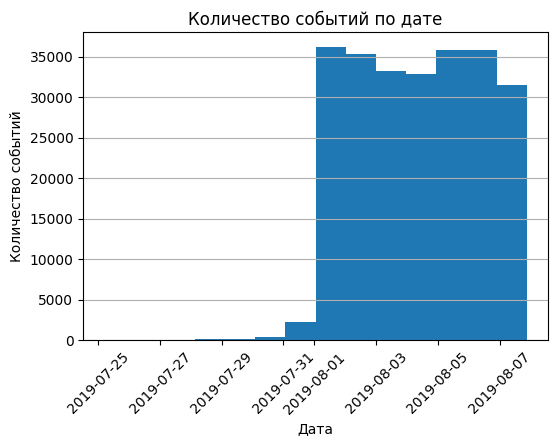

In [24]:
plt.figure(figsize = (6, 4))

plt.hist(logs['event_datetime'], bins=14) 
# plt.gca().set_xticks(ordersByUsers["transactions"].unique())
plt.title('Количество событий по дате')
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.grid(axis='y')
plt.show()

В период с 2019-08-01 по 2019-08-07 было собрано наибольшее кол-во данных, при этом в любой другой день было собрано более чем в 10 раз меньше записей событий. Для исключения негативного влияния при изучении A/A/B-теста, данные за период вне 2019-08-01 по 2019-08-07 будут отброшены:

In [25]:
logs_actual_period = logs.loc[logs['event_datetime'] >= dt.datetime(2019, 8, 1)]
logs_actual_period['event_date'].value_counts().sort_index()

2019-08-01    36141
2019-08-02    35554
2019-08-03    33282
2019-08-04    32968
2019-08-05    36058
2019-08-06    35788
2019-08-07    31096
Name: event_date, dtype: int64

Более старые, данные за неактуальный период были отброшены и оставлены только полные данные за период с 2019-08-01 по 2019-08-07.

При отбрасывании данных за неактуальный период произошли следующие изменения:

In [26]:
print('Кол-во событий уменьшилось на ' + str(len(logs.index) - len(logs_actual_period.index)))
print('Кол-во событий в процентном выражении уменьшилось на ' + str(round((len(logs.index) - len(logs_actual_period.index)) / (len(logs.index)), 3)*100) + '%')
print('Кол-во пользователей уменьшилось на ' + str(logs['user_id'].nunique() - logs_actual_period['user_id'].nunique()))

print('Кол-во событий в процентном выражении уменьшилось на ' + str(round((logs['user_id'].nunique() - logs_actual_period['user_id'].nunique()) / (logs['user_id'].nunique()), 3)*100) + '%')

Кол-во событий уменьшилось на 2826
Кол-во событий в процентном выражении уменьшилось на 1.2%
Кол-во пользователей уменьшилось на 17
Кол-во событий в процентном выражении уменьшилось на 0.2%


Количество событий и пользователей при отбрасывании данных за неактуальный период уменьшилось незначительно, что позволяет продолжить исследование.

## Проверка корректности распредений в группах

Перед анализом A/A/B-теста следует убедится, что пользователи в датафрейме *logs_actual_period* корректно распределены по группам. Для этого убедимся, что один и тот же пользователь не попадал в две группы, а был только в одной на протяжении сбора данных для теста, а также посмотрим общее кол-во записей для групп.

In [27]:
print('Данные по кол-ву пользователей:')
print('Всего записей событий для обеих групп: ' + str(logs_actual_period['user_id'].nunique()))
print('Пользователей в контрольной группе 246: ' + str(logs_actual_period.query('group == 246')['user_id'].nunique()))
print('Пользователей в контрольной группе 247: ' + str(logs_actual_period.query('group == 247')['user_id'].nunique()))
print('Пользователей в тестовой группе 248: ' + str(logs_actual_period.query('group == 248')['user_id'].nunique()))
(logs_actual_period['group'].value_counts(normalize=True).sort_values().round(4) * 100).astype('str') + '%'

Данные по кол-ву пользователей:
Всего записей событий для обеих групп: 7534
Пользователей в контрольной группе 246: 2484
Пользователей в контрольной группе 247: 2513
Пользователей в тестовой группе 248: 2537


247                 31.97%
246                 32.92%
248    35.099999999999994%
Name: group, dtype: object

Пользователей в группе B (248) несколько больше относительно первой и второй контрольной группы (246 и 247), является нормальным для проведения исследования.

Для того чтобы найти пользователей попавших одновременно в несколько групп, создадим три датафрейма *group_246*, *group_247* и *group_248* с пользователями из различных групп:

In [28]:
group_246 = logs_actual_period.loc[logs_actual_period['group'] == 246]
group_247 = logs_actual_period.loc[logs_actual_period['group'] == 247]
group_248 = logs_actual_period.loc[logs_actual_period['group'] == 248]

In [29]:
double_event = (
    logs_actual_period[((logs_actual_period['user_id'].isin(group_246['user_id'])) & (logs_actual_period['user_id'].isin(group_247['user_id'])))
                     | ((logs_actual_period['user_id'].isin(group_246['user_id'])) & (logs_actual_period['user_id'].isin(group_248['user_id'])))
                     | ((logs_actual_period['user_id'].isin(group_247['user_id'])) & (logs_actual_period['user_id'].isin(group_248['user_id'])))]
)
len(double_event.index)

0

Пользователей попавших одновременно в несколько групп не обнаружено.

## Итоги изучения данных

При изучении периода проведения тестирования, были отброшены записи до 2019-08-01, где кол-во событий более чем в 10 меньше, чем за любой день августа. При этом, в результате отсечения неактульных записей, общее кол-во данных в датафрейме снизилось всего на 1.4%. Таким образом, в качестве актуального периода выбран 2019-08-01 — 2019-08-07.  
Проверка корректности собранных данных не выявила факты попадания записей событий одних и тех же пользователей в разные группы.

# Изучение воронки событий <a id='funnel'></a>

In [30]:
logs_actual_period['event_name'].unique()

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'CartScreenAppear', 'PaymentScreenSuccessful'], dtype=object)

В датафрейме встречаются следующие события:
- **MainScreenAppear** — переход на главный экран;
- **OffersScreenAppear** — переход на экран предложений;
- **CartScreenAppear** — переход на экран корзины;
- **PaymentScreenSuccessful** — переход на экран успешной оплаты;
- **Tutorial** — переход на экран инструкции по использованию приложения (туториал).

## Изучение частоты событий

In [31]:
logs_actual_period['event_name'].value_counts().sort_values(ascending=False)

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Наиболее часто встречающееся событие — *MainScreenAppear*. Наиболее редкое — *Tutorial*.

In [32]:
event_per_user = (
    logs_actual_period.groupby('event_name', as_index=False)
    .agg({'user_id': 'nunique'})
)
event_per_user = event_per_user.rename(columns={'user_id': 'users'})
event_per_user['percent_of_user'] = (event_per_user['users'] / logs_actual_period['user_id'].nunique() * 100).round(2).astype('str') + '%'
event_per_user.sort_values(by='users', ascending=False)

,event_name,users,percent_of_user
1,MainScreenAppear,7419,98.47%
2,OffersScreenAppear,4593,60.96%
0,CartScreenAppear,3734,49.56%
3,PaymentScreenSuccessful,3539,46.97%
4,Tutorial,840,11.15%


Так же как и в общем числе событий, доля пользователей, которые хоть раз совершали событие, принадлежит событию *MainScreenAppear* и равна 98.47% от общего числа пользователей.  
Минимальная доля 11.15% принадлежит событию *Tutorial*.

## Порядок событий <a id='Порядок_событий'></a>

Порядок событий пользователя в приложении выстраивается в следующую цепочку:
1. Переход на главный экран;
2. Переход на экран предложений;
3. Переход на экран корзины;
4. Переход на экран успешной оплаты.

При этом экран инструкции по использованию приложения (туториал) не обязателен и многие пользователи его пропускают. Потому при расчёте воронки следует учитывать перечисленные события за исключением события *Tutorial*

## Расчёт воронки событий

In [33]:
funnel = (
    logs_actual_period.loc[logs_actual_period['event_name'] != 'Tutorial']
    .groupby('event_name', as_index=False)
    .agg({'user_id': 'count'})
    .sort_values(by='user_id', ascending=False)
    .reset_index(drop=True)
)
funnel = funnel.rename(columns={'user_id': 'counts'})
funnel['percent'] = 100.0

for i in range(1, len(funnel.index)):
    funnel['percent'][i] = funnel['counts'][i] / funnel['counts'][i-1] * 100
funnel['percent'] = funnel['percent'].round(2).astype('str') + '%'
funnel

,event_name,counts,percent
0,MainScreenAppear,117328,100.0%
1,OffersScreenAppear,46333,39.49%
2,CartScreenAppear,42303,91.3%
3,PaymentScreenSuccessful,33918,80.18%


При переходе с главного экрана *(MainScreenAppear)* на экран предложений *(OffersScreenAppear)* теряется больше всего пользователей — с одного на другой экран менее 40% переходов.

In [34]:
round(funnel['counts'][3] / funnel['counts'][0] * 100, 2)

28.91

28.91% пользователей доходит от первого события *(MainScreenAppear)* до оплаты *(OffersScreenAppear)*.

## Итоги воронки событий

В результате изучения воронки событий был определён порядок событий: 
1. Переход на главный экран;
2. Переход на экран предложений;
3. Переход на экран корзины;
4. Переход на экран успешной оплаты.

Исключено из дальнейшего анализа событие *Tutorial*, т.к. оно не является определяющим и участвующим в процессе оформления заказа.  
Удалось установить на каком из шагов происходит наибольшая потеря пользователей. Самый низкий процент при переходе с главного экрана на экран предложений — менее 40% переходов.  
Процент пользователей проходящих от первого экрана до покупки равен 28.91%.

# Изучение результатов A/A/B-теста <a id='ab-test_explore'></a>

По итогам изучения данных удалось установить, что количество пользователей в группах следующее:

- Контрольная группа 246: 2484 (31.97%)
- Контрольная группа 247: 2513 (32.92%)
- Тестовая группа 248: 2537 (35.1%)

Создадим объединённую контрольную группу *249*, которая будет состоять из всех записей групп *246* и *247*:

## Сравнение долей пользователей совершивших события для различных групп

Сравним доли пользователей совершивших события в различных группах. Для этого сформулируем гипотезы:
- Нулевая: различий в доле пользователей совершивших событие между группами нет;
- Альтернативная: различия в доле пользователей совершивших событие между группами есть.

При изучении результатов теста будем проводить проверку гипотезы о равенстве долей между группами для каждого события при помощи z-теста.

Критический уровень статистической значимости принимаем равным 0.05.

In [35]:
alpha = 0.05  # критический уровень статистической значимости

In [36]:
# Объявим функцию z_test для проверки гипотезы о равенстве долей между группами и сравнения долей пользователей.
# Параметры функции это сравниваемые группы (group_1, group_2) и событие (event) по которому они сравниваются

def z_test(group_1, group_2, event):
    
    print('Сравнение долей пользователей совершивших событие ' 
          + event 
          + ' для групп ' 
          + str(group_1['group'].reset_index(drop=True)[0]) 
          + ' и ' 
          + str(group_2['group'].reset_index(drop=True)[0])
          + ':'
         )
    
    # число пользователей, совершивших это событие в группе
    count_group_1 = int(group_1.groupby('event_name', as_index=False).agg({'user_id': 'nunique'}).query('event_name == @event')['user_id'])
    
    # доля пользователей, совершивших это событие в группе
    percent_group_1 = count_group_1 / group_1['user_id'].nunique()
    
    count_group_2 = int(group_2.groupby('event_name', as_index=False).agg({'user_id': 'nunique'}).query('event_name == @event')['user_id'])
    percent_group_2 = count_group_2 / group_2['user_id'].nunique()
    
    # пропорция успехов в первой группе:
    p1 = percent_group_1/count_group_1
    
    # пропорция успехов во второй группе:
    p2 = percent_group_2/count_group_2
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (percent_group_1 + percent_group_2) / (count_group_1 + count_group_2)
    
    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/count_group_1 + 1/count_group_2))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение:', '%.3f' % p_value)
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница.')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.')
    
    if (percent_group_1 / percent_group_2 - 1) < 0:
        print('Доля пользователей совершивших события в группе ' 
              + str(group_2['group'].reset_index(drop=True)[0]) 
              + ' больше чем в группе на ' 
              + str(group_1['group'].reset_index(drop=True)[0]) 
              + ' и составляет ' 
              + str('%.2f' % abs((round(percent_group_1 / percent_group_2 - 1, 4) * 100))) 
              + '%.')
    else:
        print('Доля пользователей совершивших события в группе ' 
              + str(group_1['group'].reset_index(drop=True)[0]) 
              + ' больше чем в группе на ' 
              + str(group_2['group'].reset_index(drop=True)[0]) 
              + ' и составляет ' 
              + str('%.2f' % (round(percent_group_1 / percent_group_2 - 1, 4) * 100)) 
              + '%.')
    print('\n')
    

### Сравнение контрольных групп 246 и 247

Вызывем функцию *z_test* для групп 246 и 247. Вызывать фунцию будем в цикле *for* перебирающем наименования событий отсортированных по их количеству. Из перечисления исключено событие *"Tutorial"*:

In [37]:
for event in logs_actual_period.loc[logs_actual_period['event_name'] != 'Tutorial']['event_name'].value_counts().sort_values(ascending=False).index:
    z_test(group_246, group_247, event)

Сравнение долей пользователей совершивших событие MainScreenAppear для групп 246 и 247:
p-значение: 0.993
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Доля пользователей совершивших события в группе 246 больше чем в группе на 247 и составляет 0.11%.


Сравнение долей пользователей совершивших событие OffersScreenAppear для групп 246 и 247:
p-значение: 0.995
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Доля пользователей совершивших события в группе 246 больше чем в группе на 247 и составляет 2.63%.


Сравнение долей пользователей совершивших событие CartScreenAppear для групп 246 и 247:
p-значение: 0.995
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Доля пользователей совершивших события в группе 246 больше чем в группе на 247 и составляет 3.46%.


Сравнение долей пользователей совершивших событие PaymentScreenSuccessful для групп 246 и 247:
p-значение: 0.996
Не получилось отвергнуть ну

Полученные данные говорят о том, что между контрольными группами 246 и 247 есть небольшие различия, которые при этом не являются статистически значимыми.

### Сравнение контрольной групы 246 и тестовой группы 248

In [38]:
for event in logs_actual_period.loc[logs_actual_period['event_name'] != 'Tutorial']['event_name'].value_counts().sort_values(ascending=False).index:
    z_test(group_246, group_248, event)

Сравнение долей пользователей совершивших событие MainScreenAppear для групп 246 и 248:
p-значение: 0.988
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Доля пользователей совершивших события в группе 246 больше чем в группе на 248 и составляет 0.37%.


Сравнение долей пользователей совершивших событие OffersScreenAppear для групп 246 и 248:
p-значение: 0.991
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Доля пользователей совершивших события в группе 246 больше чем в группе на 248 и составляет 2.87%.


Сравнение долей пользователей совершивших событие CartScreenAppear для групп 246 и 248:
p-значение: 0.992
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Доля пользователей совершивших события в группе 246 больше чем в группе на 248 и составляет 5.12%.


Сравнение долей пользователей совершивших событие PaymentScreenSuccessful для групп 246 и 248:
p-значение: 0.992
Не получилось отвергнуть ну

Между контрольной группой 246 и тестовой группой 248 есть небольшие различия, но они не являются статистически значимыми.

### Сравнение контрольной групы 247 и тестовой группы 248

In [39]:
for event in logs_actual_period.loc[logs_actual_period['event_name'] != 'Tutorial']['event_name'].value_counts().sort_values(ascending=False).index:
    z_test(group_247, group_248, event)

Сравнение долей пользователей совершивших событие MainScreenAppear для групп 247 и 248:
p-значение: 0.995
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Доля пользователей совершивших события в группе 247 больше чем в группе на 248 и составляет 0.27%.


Сравнение долей пользователей совершивших событие OffersScreenAppear для групп 247 и 248:
p-значение: 0.996
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Доля пользователей совершивших события в группе 247 больше чем в группе на 248 и составляет 0.23%.


Сравнение долей пользователей совершивших событие CartScreenAppear для групп 247 и 248:
p-значение: 0.996
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Доля пользователей совершивших события в группе 247 больше чем в группе на 248 и составляет 1.61%.


Сравнение долей пользователей совершивших событие PaymentScreenSuccessful для групп 247 и 248:
p-значение: 0.996
Не получилось отвергнуть ну

Между контрольной группой 246 и тестовой группой 248 есть небольшие различия, но они не являются статистически значимыми.

### Сравнение объединённой контрольной групы 249 и тестовой группы 248

Создадим объединённую контрольную групы *249*, которая состоит из контрольных групп *246* и *247*:

In [40]:
group_249 = pd.concat([group_246, group_247])
group_249['group'] = 249

In [41]:
for event in logs_actual_period.loc[logs_actual_period['event_name'] != 'Tutorial']['event_name'].value_counts().sort_values(ascending=False).index:
    z_test(group_249, group_248, event)

Сравнение долей пользователей совершивших событие MainScreenAppear для групп 249 и 248:
p-значение: 0.628
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Доля пользователей совершивших события в группе 249 больше чем в группе на 248 и составляет 0.32%.


Сравнение долей пользователей совершивших событие OffersScreenAppear для групп 249 и 248:
p-значение: 0.703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Доля пользователей совершивших события в группе 249 больше чем в группе на 248 и составляет 1.54%.


Сравнение долей пользователей совершивших событие CartScreenAppear для групп 249 и 248:
p-значение: 0.732
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Доля пользователей совершивших события в группе 249 больше чем в группе на 248 и составляет 3.36%.


Сравнение долей пользователей совершивших событие PaymentScreenSuccessful для групп 249 и 248:
p-значение: 0.738
Не получилось отвергнуть ну

Между объединённой контрольной групой 249 и тестовой группой 248 есть небольшие различия, но они не являются статистически значимыми.

## Проверка уровня значимости

Ранее при проверках уровень значимости был выбран равным 0.05.  
Чтобы снизить групповую вероятность ошибки первого рода и скорректировать уровнь значимости, применименяют методы Бонферрони, Холма и Шидака.

Например, поскольку при сравнении долей пользователей было выполнено 16 тестов (4 теста в каждом по 4 гипотезы), то согласно методу Бонферрони уровень значимости должен быть равен 0.003125:

In [42]:
0.05 / 16

0.003125

## Итоги изучения результатов теста

Между контрольными группами 246, 247, объединённой контрольной групой 249 и тестовой группой 248 есть небольшие различия, но при этом все они не являются статистически значимыми.  
Это значит, что изменение шрифта для тестовой группы 248 на данном этапе наблюдений не значимого влияния.

# Общий вывод <a id='conclusion'></a>

В ходе исследования была изучена воронка продаж, а также результаты A/A/B-теста.  
Рассматривался период 2019-08-01 — 2019-08-07.

**Воронка продаж**  
В результате изучения воронки продаж [определён порядок событий](#Порядок_событий) приводящий пользователя от первого экрана до покупки.  
Процент пользователей проходящих от первого экрана до покупки равен 28.91%.  
Наибольшая потеря пользователей происходит при переходе с главного экрана на экран предложений — наблюдается чуть менее 40% переходов. Это потенциальная точка роста.

**Результаты A/A/B-теста**
Между контрольными и тестовой группой есть лишь небольшие различия, которые не являются статистически значимыми.  
Таким образом, изменение шрифта для тестовой группы 248 не оказало влияния на поведение пользователей мобильного приложения.